# <center> AI Preventive Maintenance Classifier Project <center>

Author: Matheus Vilar Mota Santos 

Contact: vilarmms@gmail.com

Likedin: https://www.linkedin.com/in/matheus-vilar-03708292/

## Introduction

A logistics company seeks to minimize vehicle maintenance expenses through the development of a supervised classification AI solution. The primary objective is to automate preventive repair decisions for the company's fleet, specifically targeting the air system, in order to reduce the high costs associated with delayed failure detection.

Despite maintaining a relatively stable fleet size, the company has experienced a significant increase in air system maintenance costs over the past three years. The following chart illustrates this trend:

Historical Data (Blue): Represents the actual maintenance costs provided by the client.
Projected Data (Red): Shows the anticipated maintenance costs for future years, assuming the current trend persists.
The AI solution aims to predict and prevent costly air system failures by analyzing relevant vehicle data, thereby optimizing maintenance schedules and reducing overall expenses.

/tmp/ipykernel_41213/3453948953.py:79: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().remove()


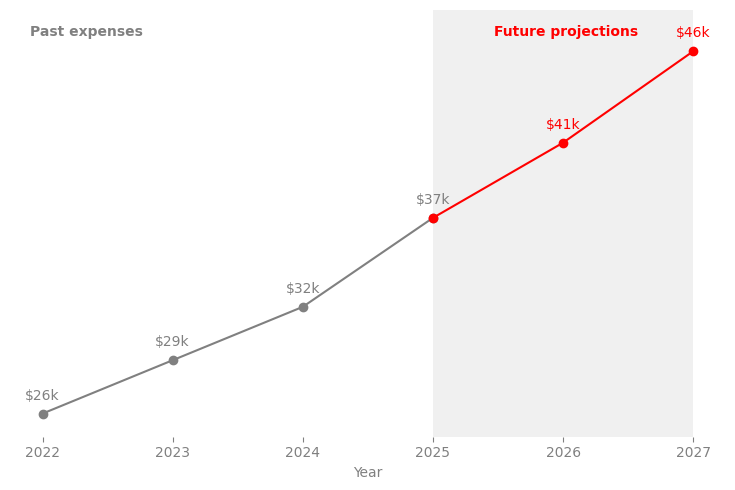

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import matplotlib.patches as patches

# Example data
years = np.array([2022, 2023, 2024, 2025])
costs = np.array([26000, 29000, 32000, 37000])

def exponential_func(x, a, b):
    return a * np.exp(b * (x - 2017))

# Fit the exponential model
params_exp, _ = curve_fit(exponential_func, years, costs)

# Extract the fitted parameters
a_exp, b_exp = params_exp

# Project costs for future years
years_proj = np.array([2025, 2026, 2027])
costs_proj_exp = exponential_func(years_proj, a_exp, b_exp)
costs_proj_exp[0] = costs[-1]  # Ensure the projection starts at the last actual data point

plt.figure(figsize=(8, 5))

# Get axis limits to define the gray background area
ax = plt.gca()
ymin, ymax = 0, max(costs.max(), costs_proj_exp.max()) * 1.2  # Add some padding above the highest point

# Add gray background behind projected expenses area
# Starting from the year 2025 (where projections begin)
start_year = 2025
rect = patches.Rectangle((start_year, ymin), len(years_proj)-1, ymax-ymin, 
                        linewidth=0, facecolor='#f0f0f0', zorder=0)  # Light gray with low opacity
ax.add_patch(rect)

# Plotting historical data (in gray with solid line)
plt.plot(years, costs, marker='o', linestyle='-', color='gray', zorder=2)

# Plotting projected expenses (red with solid line)
plt.plot(years_proj, costs_proj_exp, marker='o', linestyle='-', color='r', zorder=2)

# Adding labels
plt.xlabel('Year', color='gray')
plt.ylabel('')

# Set y-axis limits
plt.ylim(costs[0]*0.95, costs_proj_exp[-1]*1.05)

# Remove y-ticks
plt.yticks([])

# Add value labels to each data point
for i, (x, y) in enumerate(zip(years, costs)):
    plt.annotate(f'${int(y/1000)}k', 
                 xy=(x, y),
                 xytext=(0, 10),  # 10 points vertically above
                 textcoords='offset points',
                 ha='center',
                 color='gray',
                 zorder=3)

# Add value labels to projected points (in red)
for i, (x, y) in enumerate(zip(years_proj, costs_proj_exp)):
    # Only label the first point once (it's both the last historical and first projected)
    if i == 0 and x == years[-1]:
        continue
    plt.annotate(f'${int(y/1000)}k', 
                 xy=(x, y),
                 xytext=(0, 10),
                 textcoords='offset points',
                 ha='center',
                 color='red',
                 zorder=3)

# Remove grid and legend
plt.grid(False)
plt.legend().remove()

# Add "Projected Expenses" text annotation near the end of the red line
plt.annotate('Future projections', 
             xy=(years_proj[-2], costs_proj_exp[-2]),
             xytext=(-50, 77),
             textcoords='offset points',
             color='red',
             fontweight='bold',
             zorder=3)

plt.annotate('Past expenses',
                 xy=(years_proj[-2], costs_proj_exp[-2]),
                 xytext=(-384, 77),
                 textcoords='offset points',
                 ha='left',
                fontweight='bold',
                 color='gray',
                 zorder=3)

# Remove all spines (box around the plot)
for spine in plt.gca().spines.values():
    spine.set_visible(False)
    
# Making tick marks gray for x-axis only
plt.tick_params(axis='x', colors='gray')
plt.tick_params(axis='y', colors='gray')

plt.tight_layout()
plt.show()

To mitigate projected maintenance costs, the client requires an AI solution capable of analyzing vehicle condition data and optimizing preventive repair decisions.

The client has provided a dataset encompassing historical and current vehicle data. This dataset includes encoded features representing various vehicle conditions, along with corresponding labels indicating the necessity of repairs for each instance. This problem, therefore, is well-suited for a supervised classification AI approach.

## Exploratory Data Analysis


First, let's have insight into the dataset

In [4]:
from src.ExploratoryDataAnalysis import EDA

# Loading train and test datasets
df_train_raw = pd.read_csv("datasets/air_system_previous_years.csv", na_values=["na"])
df_test_raw = pd.read_csv("datasets/air_system_present_year.csv", na_values=["na"])

# Droping NaN in target feature
df_train_raw = df_train_raw.dropna(subset=["class"])
df_test_raw = df_test_raw.dropna(subset=["class"])

# Creating EDA object instances
eda_train = EDA(df_train_raw)
eda_test = EDA(df_test_raw)

# Concise dataset discription
eda_train.generate_concise_report("TRAIN SET")
eda_test.generate_concise_report("TEST SET")

SUMMARY REPORT: TRAIN SET

Dataset Shape: 60,000 samples × 171 features
Feature Types: 170 numeric, 1 categorical

Missing Values: 850,015 (8.28% of all data)

Top 5 Features with Missing Values:
  - br_000: 49,264 (82.11%)
  - bq_000: 48,722 (81.20%)
  - bp_000: 47,740 (79.57%)
  - bo_000: 46,333 (77.22%)
  - cr_000: 46,329 (77.22%)

Numeric Feature Insights:
  - cs_009: Highly right-skewed (skew=243.53)
  - cf_000: Highly right-skewed (skew=212.46)
  - co_000: Highly right-skewed (skew=212.46)

Categorical Feature Insights:
  - class: 2 unique values (low cardinality)
    Dominant value: 'neg' (98.3%)

Recommended Next Steps:
  1. Address missing values (use fill_missing_values method)
  2. Check for outliers in highly skewed numeric features
  3. Consider encoding high-cardinality categorical features
  4. Investigate correlation between features

Note: Run analyze_numeric_features() and analyze_categorical_features()
      for more detailed feature-level insights.
SUMMARY REPORT: T

The training dataset consists of 60,000 data points with 170 numerical features. The target variable is categorical and exhibits a significant class imbalance, which will be addressed during model training. Initially, missing values (NaNs) in the numerical features will be imputed using the median for skewed distributions and the mean for normally distributed features.

To address empty values, the adopted approach considers median and means for skewed and normal feature distributions, respectively.

In [5]:
df_filled_train, fill_methods_train = eda_train.fill_missing_values()
df_filled_test, fill_methods_test = eda_test.fill_missing_values()


Filling Missing Values:
  - ab_000: Used median (0.000) due to skewness of 28.085
  - ac_000: Used median (152.000) due to skewness of 1.785
  - ad_000: Used median (126.000) due to skewness of 212.459
  - ae_000: Used median (0.000) due to skewness of 90.588
  - af_000: Used median (0.000) due to skewness of 51.672
  - ag_000: Used median (0.000) due to skewness of 153.388
  - ag_001: Used median (0.000) due to skewness of 76.076
  - ag_002: Used median (0.000) due to skewness of 37.026
  - ag_003: Used median (0.000) due to skewness of 23.788
  - ag_004: Used median (3672.000) due to skewness of 22.292
  - ag_005: Used median (176020.000) due to skewness of 9.139
  - ag_006: Used median (930336.000) due to skewness of 8.272
  - ag_007: Used median (119204.000) due to skewness of 12.378
  - ag_008: Used median (1786.000) due to skewness of 35.680
  - ag_009: Used median (0.000) due to skewness of 98.289
  - ah_000: Used median (1002420.000) due to skewness of 5.535
  - ai_000: Used m

Prior to data visualization, we will assess feature correlation using Spearman's rank correlation coefficient. This method is preferred as it captures non-linear relationships between features. Identifying and removing highly correlated features can reduce redundancy, potentially mitigate overfitting, and lead to more efficient model training.

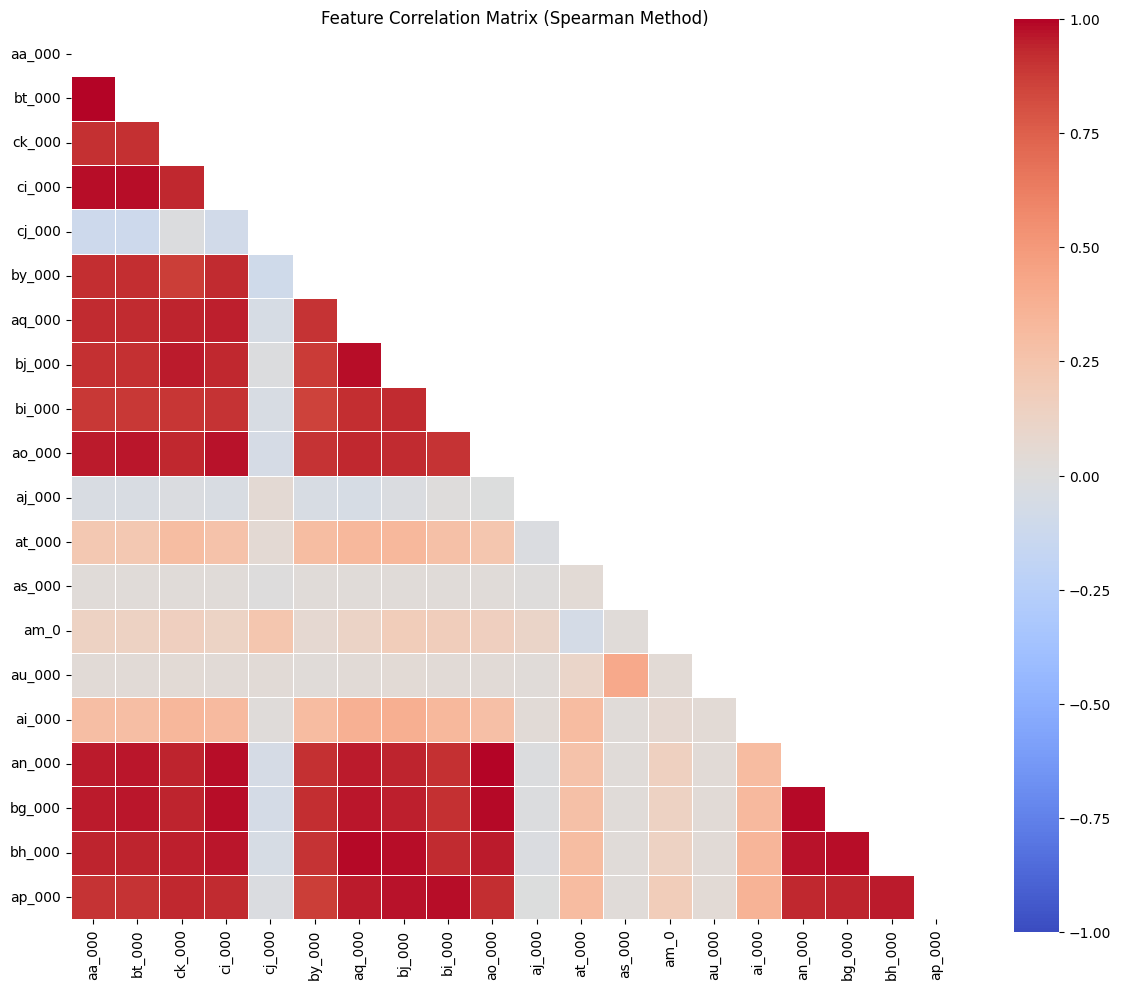


Highly Correlated Feature Pairs (|r| >= 0.7) using Spearman method:
  - aa_000 & bt_000: 1.000
  - ao_000 & an_000: 0.997
  - an_000 & bg_000: 0.991
  - ao_000 & bg_000: 0.985
  - aq_000 & bh_000: 0.985
  - bi_000 & ap_000: 0.983
  - bt_000 & ci_000: 0.983
  - bg_000 & bh_000: 0.982
  - aq_000 & bj_000: 0.981
  - ci_000 & bg_000: 0.980
  - ci_000 & an_000: 0.980
  - aa_000 & ci_000: 0.979
  - bj_000 & bh_000: 0.977
  - ci_000 & ao_000: 0.974
  - bj_000 & ap_000: 0.972
  - an_000 & bh_000: 0.971
  - bt_000 & an_000: 0.965
  - bt_000 & bg_000: 0.964
  - ci_000 & bh_000: 0.964
  - bt_000 & ao_000: 0.964
  - aq_000 & bg_000: 0.963
  - bh_000 & ap_000: 0.961
  - aa_000 & an_000: 0.961
  - aa_000 & bg_000: 0.961
  - aq_000 & ap_000: 0.960
  - aa_000 & ao_000: 0.960
  - ao_000 & bh_000: 0.957
  - ck_000 & bj_000: 0.953
  - aq_000 & an_000: 0.953
  - bj_000 & bg_000: 0.953
  - ci_000 & aq_000: 0.951
  - ck_000 & bh_000: 0.946
  - bj_000 & an_000: 0.943
  - ck_000 & an_000: 0.942
  - bt_000 & 

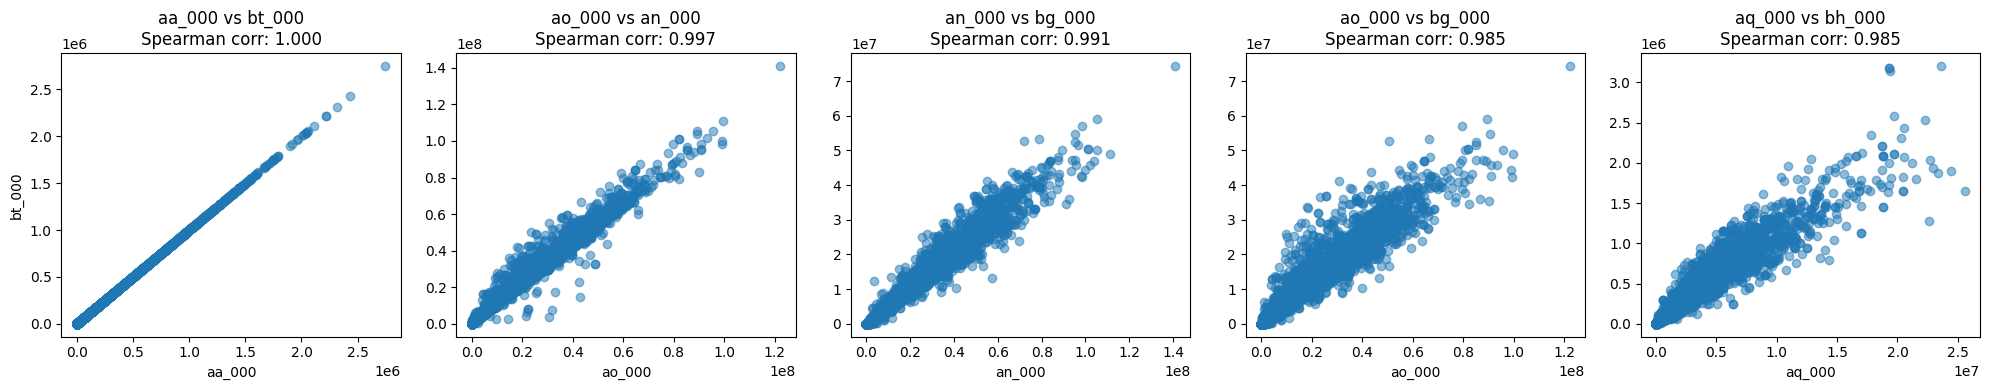


Dropping one feature from each highly correlated pair (|r| >= 0.7):
  - Keeping 'bt_000' and dropping 'aa_000' (lower variance, correlation: 1.000)
  - Keeping 'an_000' and dropping 'ao_000' (lower variance, correlation: 0.997)
  - Keeping 'an_000' and dropping 'bg_000' (lower variance, correlation: 0.991)
  - Keeping 'aq_000' and dropping 'bh_000' (lower variance, correlation: 0.985)
  - Keeping 'ap_000' and dropping 'bi_000' (lower variance, correlation: 0.983)
  - Keeping 'ci_000' and dropping 'bt_000' (lower variance, correlation: 0.983)
  - Keeping 'bj_000' and dropping 'aq_000' (lower variance, correlation: 0.981)
  - Keeping 'ci_000' and dropping 'an_000' (lower variance, correlation: 0.980)
  - Keeping 'ap_000' and dropping 'bj_000' (lower variance, correlation: 0.972)
  - Keeping 'ci_000' and dropping 'ck_000' (lower variance, correlation: 0.937)
  - Keeping 'ci_000' and dropping 'by_000' (lower variance, correlation: 0.927)
  - Keeping 'ci_000' and dropping 'ap_000' (lower v

In [6]:
df_cleaned_train, drop_feats = eda_train.drop_correlated_features()
df_cleaned_test = df_filled_test.drop(columns=drop_feats)
del df_filled_train, df_filled_test

Following the removal of highly correlated features, let's employ t-SNE (t-distributed Stochastic Neighbor Embedding) for embedded feature visualization. This visualization method maps high-dimensional data points to a lower-dimensional space while preserving the pairwise similarities of the original data. This helps reveal clusters and patterns in the data that might not be apparent in the original high-dimensional space.

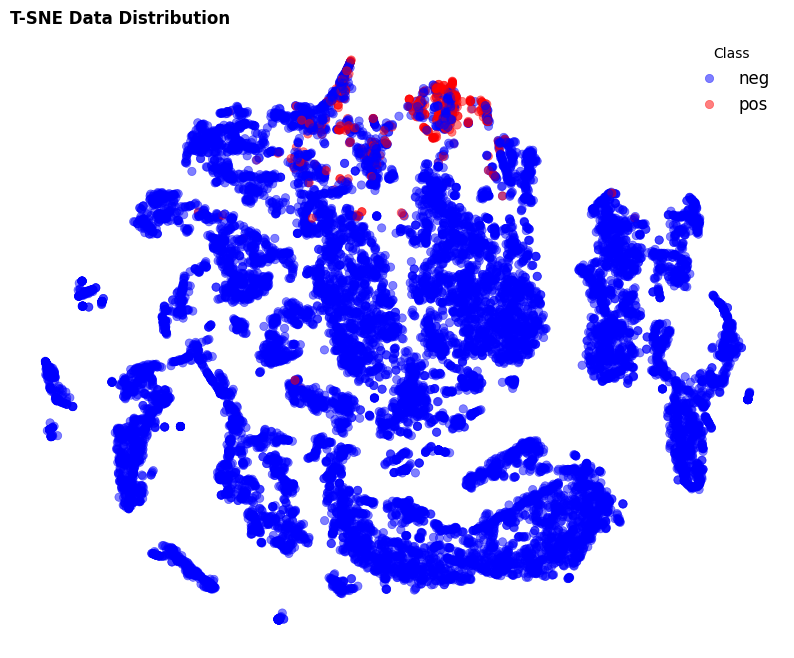

In [7]:
import seaborn as sns

def tsne_visualization(df: pd.DataFrame, perplexity=50, learning_rate=100, random_state=42):

    from sklearn.manifold import TSNE

    """Perform t-SNE visualization on df with color-coded classes."""
    # Ensure 'class' is present
    if 'class' not in df.columns:
        raise ValueError("Column 'class' is missing from DataFrame.")

    # Extract features (all columns except 'class')
    features = df.drop(columns=['class'])

    # Apply t-SNE
    tsne = TSNE(n_components=2, perplexity=perplexity, learning_rate=learning_rate, random_state=random_state)
    tsne_results = tsne.fit_transform(features)

    # Assuming tsne_results and df are already defined

    plt.figure(figsize=(10, 8))
    sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=df['class'], palette={'pos': 'red', 'neg': 'blue'}, alpha=0.5, edgecolor=None) #removed edgecolor and changed alpha

    plt.title('T-SNE Data Distribution', loc='left', fontweight='bold') #changed title, aligned left, bold

    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks

    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)

    plt.legend(title='Class', fontsize='large', frameon=False)

    plt.show()


tsne_visualization(df_cleaned_test)


The t-SNE visualization reveals a non-linear distribution of classes, indicating that a simple linear model may not be effective. Therefore, we will proceed with a LightGBM (Light Gradient Boosting Machine) model to capture the inherent non-linear relationships within the data

Let's now focus on addressing the client's needs. The models proposed in the next section aim to reduce vehicle maintenance expenses. Our objective is to train the models to minimize the client's costs, taking into account the expenses associated with failure detection as follows:

- Vehicle inspection detects an error (true positive): $25
- Vehicle inspection does not detect an error (false positive): $10
- Vehicle damaged and not sent for repair (false negative): $500

Therefore, there is a trade-off between identifying unnecessary vehicle inspections (false positives) and not inspecting damaged vehicles (false negatives). As such, the following cost function is employed to assist the AI in making decisions to reduce expenses.

In [8]:
# Create and optimize the model
from src.Classifier import LightGBM as LGBM
import os

X_train = df_cleaned_train.drop(columns=['class'])
X_test = df_cleaned_test.drop(columns=['class'])

# Convert string labels to binary values
y_train = df_cleaned_train['class'].apply(lambda x: 1 if x == 'pos' else 0)
y_test = df_cleaned_test['class'].apply(lambda x: 1 if x == 'pos' else 0)

/home/matheus/Desktop/Projetos/SteadyWheels-/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
train_model = True
lgbm_model_dir = 'models/lightboost'

if train_model:
    lgbm = LGBM(n_trials=200)
    lgbm.optimize(X_train, y_train, X_test, y_test)
    lgbm.fit(X_train, y_train)
    os.makedirs(lgbm_model_dir,exist_ok=True)
    lgbm.save_model(os.path.join(lgbm_model_dir,'model.pkl'))

else: 
    lgbm = LGBM.load_model(os.path.join(lgbm_model_dir,'model.pkl'))


[I 2025-04-02 20:44:19,638] A new study created in memory with name: no-name-2d11f9c8-d2b8-451d-90bc-bd9a5201a462


Starting hyperparameter optimization with 200 trials...


[I 2025-04-02 20:44:22,314] Trial 0 finished with value: -22340.0 and parameters: {'n_estimators': 224, 'learning_rate': 0.017890790139881922, 'max_depth': 4, 'num_leaves': 60, 'min_child_samples': 94, 'subsample': 0.7116779285872056, 'colsample_bytree': 0.919708845286213, 'reg_alpha': 1.0761881595027243, 'reg_lambda': 0.0004024562318563956}. Best is trial 0 with value: -22340.0.
[I 2025-04-02 20:44:27,220] Trial 1 finished with value: -23570.0 and parameters: {'n_estimators': 446, 'learning_rate': 0.015536166180203205, 'max_depth': 6, 'num_leaves': 75, 'min_child_samples': 53, 'subsample': 0.9521552701044418, 'colsample_bytree': 0.8878957528475575, 'reg_alpha': 6.791023032239336, 'reg_lambda': 4.545606531955747e-05}. Best is trial 0 with value: -22340.0.
[I 2025-04-02 20:44:28,463] Trial 2 finished with value: -21890.0 and parameters: {'n_estimators': 86, 'learning_rate': 0.04751304674253236, 'max_depth': 6, 'num_leaves': 24, 'min_child_samples': 67, 'subsample': 0.9107878704518722, '

Optimization completed in 405.66 seconds.

Best hyperparameters found:
  n_estimators: 475
  learning_rate: 0.0223028161227767
  max_depth: 2
  num_leaves: 99
  min_child_samples: 62
  subsample: 0.8887481288875493
  colsample_bytree: 0.941650742924195
  reg_alpha: 2.9421047879325726e-05
  reg_lambda: 1.9637282033740937e-05
Model saved to models/lightboost/model.pkl


A LightGBM model has been trained with optimized hyperparameters. Given the project's sensitivity to the classification threshold, due to the significant cost disparity between false negatives and false positives, a thorough threshold analysis is crucial to identify an optimal value that minimizes overall costs.

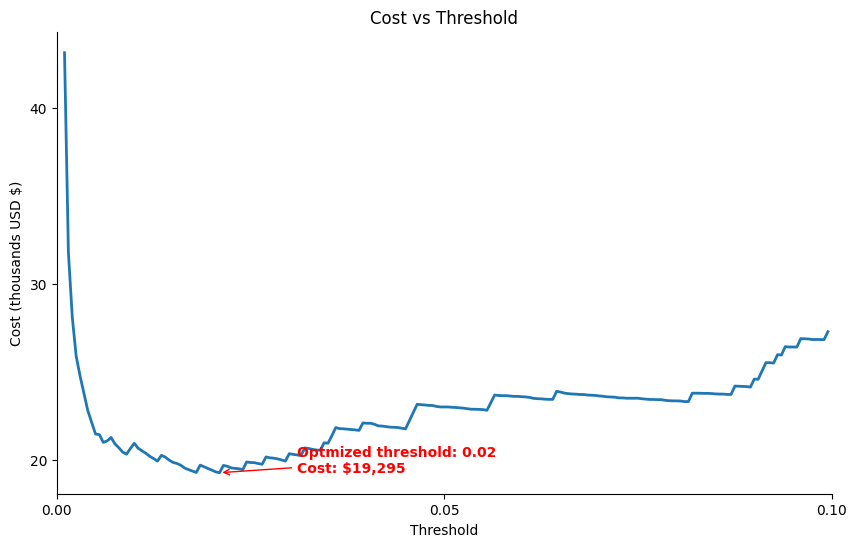


Model Evaluation Results (threshold=0.021000):
  Cost function: 19295
  Accuracy: 0.961
  ROC AUC: 0.995
  Precision (Class 1): 0.375
  Recall (Class 1): 0.979
  F1 Score (Class 1): 0.542


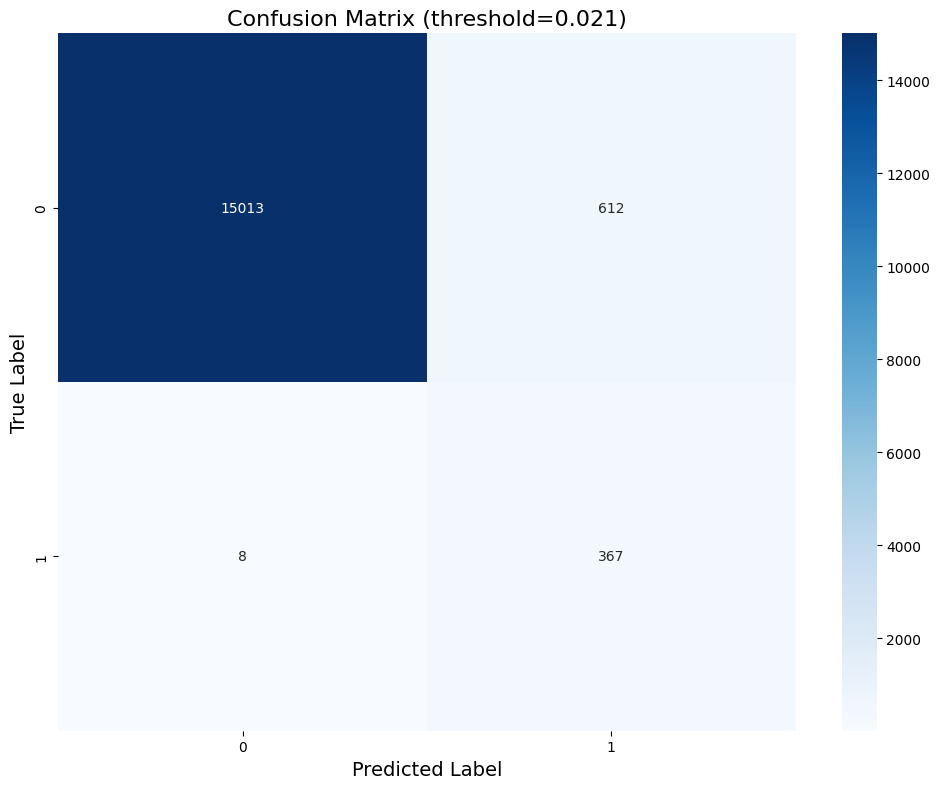

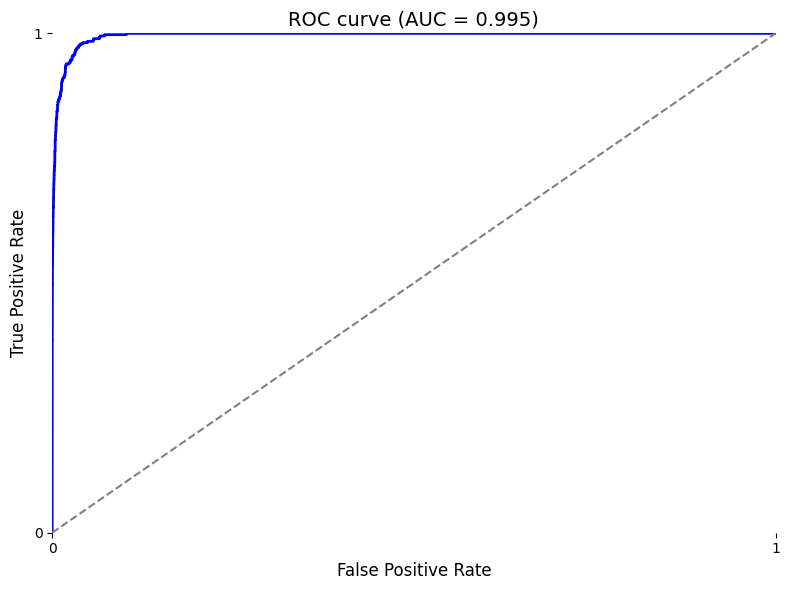

In [10]:
# Optimal 
optimal_threshold = lgbm.find_optimal_threshold(X_test, y_test)

# 5. Evaluate on test data using the optimal threshold
results = lgbm.evaluate(X_test, y_test, threshold=optimal_threshold)

Note that, due to the different in cost of false positives and negatives drives a low precision (37.5%) but a large recall (97.9%) for the class concerning malfunctioned vehicules. Nevertheless, the overall cost of is considerably lower than it would without the current model implementation ($19,295 against $41,000). Notably, the high area under curve and accuracy are mostly driven by correct predictions of vehicules without requirign repair.

## Savings analysis

The following graph illustrates the potential savings in the upcoming years if the current Light GBM model is implemented the client's infrastructure.

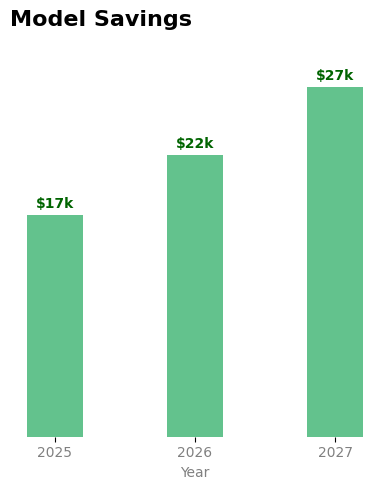

In [15]:
# Future years for projection
years_proj = np.array([2025, 2026, 2027])

# Current costs (from your existing data)
current_costs = np.array([37000, 41700, 47000])  # Keeping your exponential projection

# AI model costs with 10% growth each year (negative decay)
ai_costs = np.array([19625])  # Starting value for 2025
# Apply 10% growth (factor of 1.1) for 2026 and 2027
for year in range(1, len(years_proj)):
    ai_costs = np.append(ai_costs, ai_costs[-1] * 1)  # 10% increase each year

# Calculate the savings (difference between current costs and AI costs)
savings = current_costs - ai_costs

plt.figure(figsize=(4, 5))

# Create bars for savings
bars = plt.bar(years_proj, savings, width=.4, color='#3CB371', alpha=0.8)  # Medium sea green color

# Add value labels on top of each bar
for i, (year, value) in enumerate(zip(years_proj, savings)):
    plt.annotate(f'${int(value/1000)}k', 
                 xy=(year, value),
                 xytext=(0, 5),
                 textcoords='offset points',
                 ha='center',
                 fontweight='bold',
                 color='#006400')  # Dark green color

# Set title aligned to the left
plt.title('Model Savings', loc='left', fontsize=16, fontweight='bold')

# Customize x-axis ticks
plt.xticks(years_proj, color='gray')

# Remove y-ticks
plt.yticks([])

# Set labels
plt.xlabel('Year', color='gray')
plt.ylabel('')

# Set y-axis limits with padding
plt.ylim(0, savings.max() * 1.15)

# Remove spines
for spine in plt.gca().spines.values():
    spine.set_visible(False)

# Remove grid
plt.grid(False)

plt.tight_layout()
plt.show()

The AI solution is projected to save the client approximately $17,000 in the current year, with potential savings increasing in subsequent years based on the projected cost trends outlined earlier in this document, extending to 2027. These projections assume no degradation in AI prediction accuracy. However, due to the inherent uncertainty in future data distributions, it is crucial to maintain ongoing communication with the client to monitor for potential data drift in production. Changes in vehicle conditions or the introduction of new vehicles, for instance, may necessitate model retraining to ensure continued optimal performance.